<a href="https://colab.research.google.com/github/Sarvani-5/KneeOA_DL/blob/main/CONVNEXT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import convnext

# Load ConvNeXt - we'll use the base version
from tensorflow.keras.applications.convnext import ConvNeXtBase, preprocess_input

# Define class mapping
knee_classes = {'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}
class_names = list(knee_classes.keys())

# Enhanced data loader that combines both datasets
def load_combined_data(exp1_path, exp2_path, image_size=224):  # ConvNeXt typically uses 224x224
    X, y = [], []

    # Load MedicalExpert-I
    print("Loading MedicalExpert-I...")
    for class_name, class_idx in knee_classes.items():
        class_path = os.path.join(exp1_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Missing directory {class_path}")
            continue

        print(f"Processing {class_name}...", end=' ')
        count = 0
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = cv2.resize(img, (image_size, image_size))
                # Convert grayscale to RGB by repeating the channel
                img_rgb = cv2.merge([img, img, img])
                X.append(img_rgb)
                y.append(class_idx)
                count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        print(f"Loaded {count} samples")

    # Load MedicalExpert-II
    print("\nLoading MedicalExpert-II...")
    for class_name, class_idx in knee_classes.items():
        class_path = os.path.join(exp2_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Missing directory {class_path}")
            continue

        print(f"Processing {class_name}...", end=' ')
        count = 0
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = cv2.resize(img, (image_size, image_size))
                # Convert grayscale to RGB by repeating the channel
                img_rgb = cv2.merge([img, img, img])
                X.append(img_rgb)
                y.append(class_idx)
                count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        print(f"Loaded {count} samples")

    return np.array(X), np.array(y)

# Paths to your datasets - UPDATE THESE
medical_expert_I_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-I"
medical_expert_II_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-II"

# Load combined data
X, y = load_combined_data(medical_expert_I_path, medical_expert_II_path)

# Check class distribution
print("\nClass distribution in combined dataset:")
for class_name, class_idx in knee_classes.items():
    print(f"{class_name}: {np.sum(y == class_idx)} samples")

# Convert to float32 and preprocess for ConvNeXt
X = X.astype('float32')
X = preprocess_input(X)  # Preprocess for ConvNeXt
y = to_categorical(y, num_classes=5)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

# Build model using ConvNeXtBase
def build_convnext_model():
    base_model = ConvNeXtBase(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Freeze the base model layers first
    base_model.trainable = False

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model, base_model

model, base_model = build_convnext_model()
model.summary()

# Define the single best model path
best_model_path = '/content/drive/MyDrive/KneeOA/convnext_best_model.keras'

# Callbacks
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6, verbose=1),
    ModelCheckpoint(
        filepath=best_model_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# First phase - train with frozen base model
print("\nTraining top layers with frozen ConvNeXt base...")
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# Unfreeze some layers for fine-tuning
print("\nUnfreezing later ConvNeXt layers for fine-tuning...")
base_model.trainable = True
# ConvNeXt is a deep model - freeze earlier layers
# We'll keep approximately the first 50% of the network frozen
num_layers = len(base_model.layers)
for layer in base_model.layers[:int(0.5 * num_layers)]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nFine-tuning model...")
history_fine = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    epochs=150,
    initial_epoch=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# Combine histories
combined_history = {}
for key in history.history:
    combined_history[key] = history.history[key] + history_fine.history[key]

# Load the best model for evaluation
print(f"\nLoading the best model from {best_model_path}")
best_model = load_model(best_model_path)

# Evaluate the best model
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/drive/MyDrive/KneeOA/convnext_confusion_matrix.png')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/KneeOA/convnext_training_history.png')
plt.show()

# Sample predictions
def predict_sample_images(model, X_test, y_test, num_samples=5):
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices, 1):
        image = X_test[idx]
        true_class = np.argmax(y_test[idx])

        # Make prediction
        pred_probs = model.predict(np.expand_dims(image, axis=0))
        pred_class = np.argmax(pred_probs)

        # Convert image back for display
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to 0-1

        plt.subplot(1, num_samples, i)
        plt.imshow(image)
        plt.title(f"True: {class_names[true_class]}\nPred: {class_names[pred_class]}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/KneeOA/convnext_sample_predictions.png')
    plt.show()

# Display sample predictions
print("\nSample predictions on test set:")
predict_sample_images(best_model, X_test, y_test, num_samples=5)

print(f"\nThe best model has been saved to: {best_model_path}")

Loading MedicalExpert-I...
Processing 0Normal... Loaded 514 samples
Processing 1Doubtful... Loaded 477 samples
Processing 2Mild... Loaded 232 samples
Processing 3Moderate... Loaded 221 samples
Processing 4Severe... Loaded 206 samples

Loading MedicalExpert-II...
Processing 0Normal... Loaded 504 samples
Processing 1Doubtful... Loaded 488 samples
Processing 2Mild... Loaded 232 samples
Processing 3Moderate... Loaded 221 samples
Processing 4Severe... Loaded 206 samples

Class distribution in combined dataset:
0Normal: 1018 samples
1Doubtful: 965 samples
2Mild: 464 samples
3Moderate: 442 samples
4Severe: 412 samples

Training samples: 2640
Test samples: 661
350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,392,773 (432.56 MB)

 Trainable params: 25,824,773 (98.51 MB)

 Non-trainable params: 87,568,000 (334.05 MB)


Training top layers with frozen ConvNeXt base...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.3420 - loss: 2.1460
Epoch 1: val_accuracy improved from -inf to 0.54160, saving model to /content/drive/MyDrive/KneeOA/convnext_best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.3425 - loss: 2.1440 - val_accuracy: 0.5416 - val_loss: 1.2151 - learning_rate: 1.0000e-04
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.5051 - loss: 1.5100
Epoch 2: val_accuracy improved from 0.54160 to 0.64599, saving model to /content/drive/MyDrive/KneeOA/convnext_best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 62s 743ms/step - accuracy: 0.5052 - loss: 1.5097 - val_accuracy: 0.6460 - val_loss: 1.1256 - learning_rate: 1.0000e-04
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.5356 - loss: 1.4035
Epoch 3: val_accuracy did not improve from 0.64599
83/83 ━━━━━━━━━━━━━━━━━━━━ 73s 629ms/step - accuracy: 0.5358 - loss: 1.4028 - val_accuracy: 0.5946 - val_loss: 1.2182 - learning_rate: 1.0000e-04
Ep

Loading the best model from /content/drive/MyDrive/KneeOA/convnext_best_model.keras
Loading and preparing data...
Loading MedicalExpert-I...
Processing 0Normal... Loaded 514 samples
Processing 1Doubtful... Loaded 477 samples
Processing 2Mild... Loaded 232 samples
Processing 3Moderate... Loaded 221 samples
Processing 4Severe... Loaded 206 samples

Loading MedicalExpert-II...
Processing 0Normal... Loaded 504 samples
Processing 1Doubtful... Loaded 488 samples
Processing 2Mild... Loaded 232 samples
Processing 3Moderate... Loaded 221 samples
Processing 4Severe... Loaded 206 samples

Class distribution in dataset:
0Normal: 1018 samples
1Doubtful: 965 samples
2Mild: 464 samples
3Moderate: 442 samples
4Severe: 412 samples

Training samples: 2640
Test samples: 661

Evaluating model on test set...
21/21 ━━━━━━━━━━━━━━━━━━━━ 2350s 111s/step - accuracy: 0.9432 - loss: 0.2233
Test accuracy: 94.70%
Test loss: 0.2126
21/21 ━━━━━━━━━━━━━━━━━━━━ 2321s 110s/step

Confusion Matrix:
[[192  12   0   0   0]

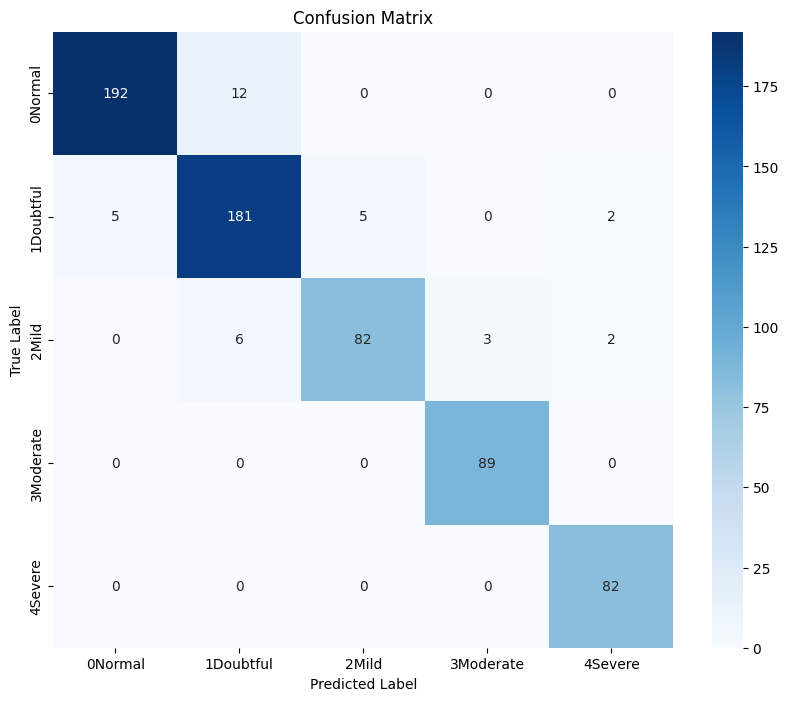


Classification Report:
              precision    recall  f1-score   support

     0Normal       0.97      0.94      0.96       204
   1Doubtful       0.91      0.94      0.92       193
       2Mild       0.94      0.88      0.91        93
   3Moderate       0.97      1.00      0.98        89
     4Severe       0.95      1.00      0.98        82

    accuracy                           0.95       661
   macro avg       0.95      0.95      0.95       661
weighted avg       0.95      0.95      0.95       661



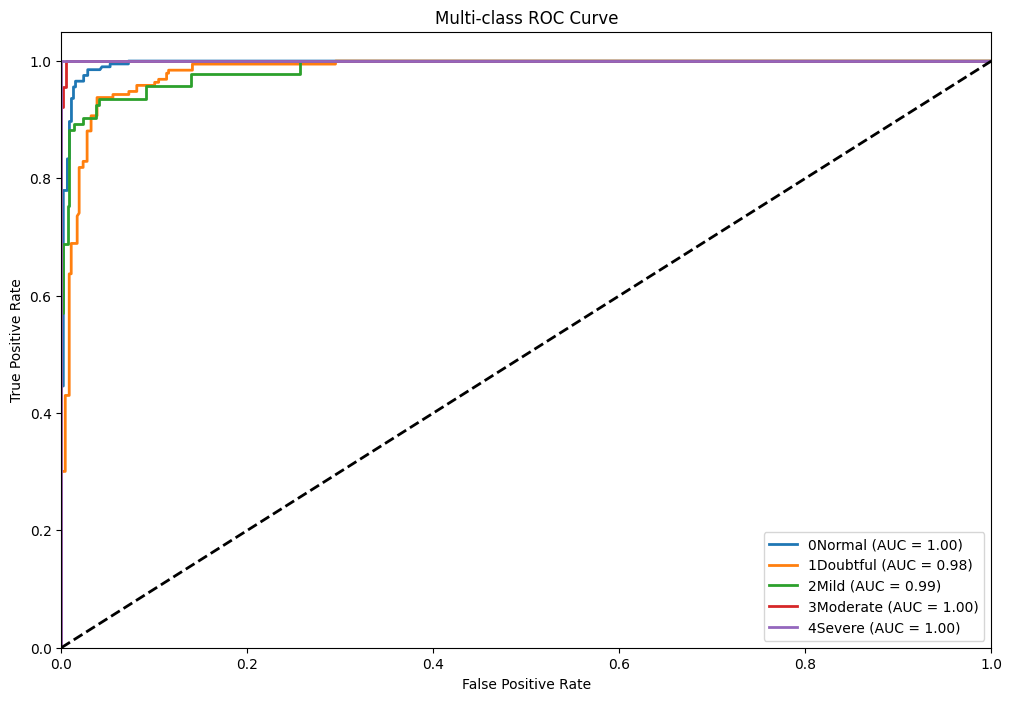


Sample predictions on test set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


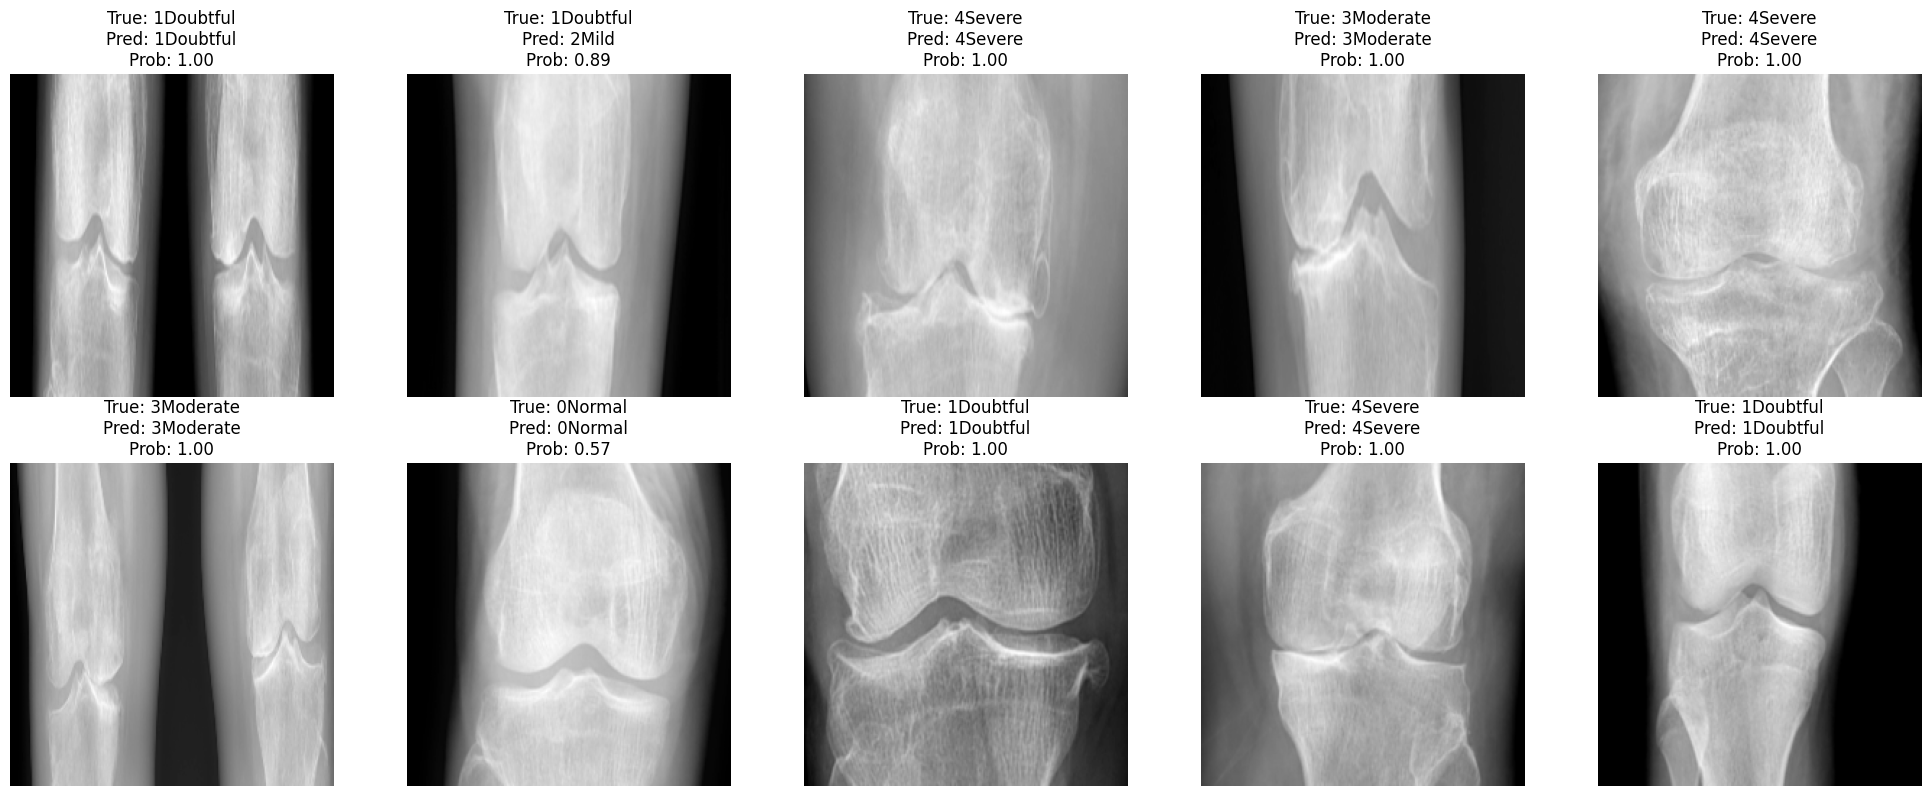

Class 0Normal accuracy: 94.12%
Class 1Doubtful accuracy: 93.78%
Class 2Mild accuracy: 88.17%
Class 3Moderate accuracy: 100.00%
Class 4Severe accuracy: 100.00%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize
import cv2
import os
from tensorflow.keras.applications.convnext import preprocess_input

# Define class mapping
knee_classes = {'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}
class_names = list(knee_classes.keys())

# Path to your saved model
best_model_path = '/content/drive/MyDrive/KneeOA/convnext_best_model.keras'

# Load the best model
print(f"Loading the best model from {best_model_path}")
best_model = load_model(best_model_path)

# Define function to load and preprocess data
def load_combined_data(exp1_path, exp2_path, image_size=224):
    X, y = [], []

    # Load MedicalExpert-I
    print("Loading MedicalExpert-I...")
    for class_name, class_idx in knee_classes.items():
        class_path = os.path.join(exp1_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Missing directory {class_path}")
            continue

        print(f"Processing {class_name}...", end=' ')
        count = 0
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = cv2.resize(img, (image_size, image_size))
                # Convert grayscale to RGB by repeating the channel
                img_rgb = cv2.merge([img, img, img])
                X.append(img_rgb)
                y.append(class_idx)
                count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        print(f"Loaded {count} samples")

    # Load MedicalExpert-II
    print("\nLoading MedicalExpert-II...")
    for class_name, class_idx in knee_classes.items():
        class_path = os.path.join(exp2_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Missing directory {class_path}")
            continue

        print(f"Processing {class_name}...", end=' ')
        count = 0
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = cv2.resize(img, (image_size, image_size))
                # Convert grayscale to RGB by repeating the channel
                img_rgb = cv2.merge([img, img, img])
                X.append(img_rgb)
                y.append(class_idx)
                count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        print(f"Loaded {count} samples")

    return np.array(X), np.array(y)

# Paths to your datasets - UPDATE THESE
medical_expert_I_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-I"
medical_expert_II_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-II"

# Load data
print("Loading and preparing data...")
X, y = load_combined_data(medical_expert_I_path, medical_expert_II_path)

# Check class distribution
print("\nClass distribution in dataset:")
for class_name, class_idx in knee_classes.items():
    print(f"{class_name}: {np.sum(y == class_idx)} samples")

# Convert to float32 and preprocess for ConvNeXt
X = X.astype('float32')
X = preprocess_input(X)  # Preprocess for ConvNeXt
y_categorical = np.eye(5)[y]  # One-hot encode

# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Evaluate model on test set
print("\nEvaluating model on test set...")
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy*100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

# Get predictions
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/drive/MyDrive/KneeOA/convnext_confusion_matrix_test.png')
plt.show()

# Classification Report
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# ROC Curve and AUC for each class
# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_true, classes=range(5))
n_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/KneeOA/convnext_roc_curve.png')
plt.show()

# Sample predictions
def predict_sample_images(model, X_test, y_true, num_samples=10):
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

    plt.figure(figsize=(20, 8))
    for i, idx in enumerate(sample_indices, 1):
        image = X_test[idx]
        true_class = y_true[idx]

        # Make prediction
        pred_probs = model.predict(np.expand_dims(image, axis=0))
        pred_class = np.argmax(pred_probs[0])

        # Convert image back for display
        display_img = (image - image.min()) / (image.max() - image.min())

        plt.subplot(2, num_samples//2, i)
        plt.imshow(display_img)
        plt.title(f"True: {class_names[true_class]}\nPred: {class_names[pred_class]}\nProb: {pred_probs[0][pred_class]:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/KneeOA/convnext_sample_predictions_test.png')
    plt.show()

# Display sample predictions
print("\nSample predictions on test set:")
predict_sample_images(best_model, X_test, y_true, num_samples=10)

# Print per-class accuracy
for i in range(5):
    class_indices = np.where(y_true == i)[0]
    class_correct = np.sum(y_pred[class_indices] == i)
    print(f"Class {class_names[i]} accuracy: {class_correct/len(class_indices)*100:.2f}%")